In [1]:
!pip install --upgrade pip
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install jax
!pip install jaxlib diffusers huggingface_hub flax transformers
!pip install orbax-checkpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html


In [2]:
!wget https://github.com/hsudhakaran/sdxl-test/raw/main/latents_file.npy

--2024-04-08 07:55:42--  https://github.com/hsudhakaran/sdxl-test/raw/main/latents_file.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hsudhakaran/sdxl-test/main/latents_file.npy [following]
--2024-04-08 07:55:42--  https://raw.githubusercontent.com/hsudhakaran/sdxl-test/main/latents_file.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097280 (2.0M) [application/octet-stream]
Saving to: ‘latents_file.npy’

latents_file.npy    100%[===================>]   2.00M  --.-KB/s    in 0.07s   

2024-04-08 07:55:43 (30.0 MB/s) - ‘latents_file.npy’ saved [2097280/2097280]



In [ ]:
from diffusers import FlaxUNet2DConditionModel
from IPython.display import clear_output

loaded_model = FlaxUNet2DConditionModel.from_pretrained('ekhalavyan/sdxl-unet')
clear_output(wait=False) # Clear the loading messages
unet_base_module = loaded_model[0] # Extract the Flax Module
# unet_variables = {'params': diff_unet[1]} # Extract the parameters

# print(unet_variables.keys())
unet_base_module

In [4]:
import jax
import numpy as np
import jax.numpy as jnp
import orbax.checkpoint

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Union
import requests
import time
from io import BytesIO

from diffusers.utils import PIL_INTERPOLATION
from diffusers.schedulers.scheduling_utils_flax import broadcast_to_shape_from_left

from safetensors.numpy import load_file

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
from diffusers import FlaxUNet2DConditionModel
import transformers
from diffusers.utils.pil_utils import numpy_to_pil
from diffusers.utils import make_image_grid
from huggingface_hub import hf_hub_download

In [5]:
dtype = jnp.bfloat16

In [ ]:
xdf = jax.random.normal(jax.random.PRNGKey(43), (1,2,3))
print(xdf.shape)
xft = jnp.squeeze(xdf)
xft.shape

In [ ]:
sdxl_params_base_unet = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

In [ ]:
sdxl_params_base_unet['params']['add_embedding']['linear_1']['kernel'].shape

In [25]:
from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
tokenizer_2 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32') 

tokenizer_config.json: 100%|██████████| 592/592 [00:00<00:00, 2.29MB/s]
vocab.json: 100%|██████████| 862k/862k [00:00<00:00, 12.1MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 34.1MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<00:00, 2.00MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:00<00:00, 16.1MB/s]
config.json: 100%|██████████| 4.19k/4.19k [00:00<00:00, 16.0MB/s]


In [ ]:
from transformers import FlaxCLIPTextModel, FlaxCLIPTextModelWithProjection
text_encoder_1 = FlaxCLIPTextModel.from_pretrained('/kaggle/input/sdxl-text-encoder-1')
text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/text-encoder-2')

In [ ]:
sdxl_params_text_encoder_1 = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_1.params)}
sdxl_params_text_encoder_2 = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_2.params)}

In [6]:
from diffusers import FlaxAutoencoderKL
from IPython.display import clear_output

loaded_model = FlaxAutoencoderKL.from_pretrained('ekhalavyan/sdxl-vae')
clear_output(wait=False) # Clear the loading messages
vae_module = loaded_model[0] # Extract the Flax Module
# vae_variables = {'params': diff_vae[1]} # Extract the parameters

sdxl_params_vae = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

# print(vae_variables.keys())
vae_module

FlaxAutoencoderKL(
    # attributes
    in_channels = 3
    out_channels = 3
    down_block_types = ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D']
    up_block_types = ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']
    block_out_channels = [128, 256, 512, 512]
    layers_per_block = 2
    act_fn = 'silu'
    latent_channels = 4
    norm_num_groups = 32
    sample_size = 1024
    scaling_factor = 0.13025
    dtype = float32
)

In [7]:
from diffusers import FlaxEulerDiscreteScheduler
loaded_model = FlaxEulerDiscreteScheduler.from_pretrained('/kaggle/input/sdxl-scheduler/config.json')
scheduler_module = loaded_model[0]
scheduler_params = loaded_model[1]
# sdxl_params_scheduler = {'params': jax.tree_util.tree_map(lambda x: jax.device_put_sharded([x], jax.devices()[6:7]), loaded_model[1])}
sdxl_params_scheduler = {'params': loaded_model[1]}

In [ ]:
sdxl_params_scheduler['params'].sigmas

In [ ]:
del loaded_model

In [ ]:
vae_scale_factor = 2 ** (len(vae_module.config.block_out_channels) - 1)
height = unet_base_module.config.sample_size * vae_scale_factor
width = unet_base_module.config.sample_size * vae_scale_factor

In [ ]:
unet_base_module.config.sample_size * vae_scale_factor //2

In [8]:
guidance_scale = 5.0
num_steps = 50
default_seed = 33
strength = 0.9 #jnp.arange(0.80,0.875,(0.875-0.80)/8.0)

In [ ]:
# prng_seed = jax.random.PRNGKey(default_seed)
# init_latent_dist = vae_module.apply(sdxl_params['vae'], processed_images, method=vae_module.encode).latent_dist
# init_latents = init_latent_dist.sample(key=prng_seed).transpose((0, 3, 1, 2))
# print(init_latents.min(), init_latents.max())
# latents = vae_module.config.get("scaling_factor") * init_latents
# print(latents.min(), latents.max())
# noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
# latent_timestep = scheduler_state.timesteps[num_steps-start_timestep].astype(int)
# latents = scheduler_module.add_noise(sdxl_params['scheduler']['params'], init_latents, noise, latent_timestep)
# print(latent_timestep, latents.min(), latents.max())
# latents = strength*latents + (1-strength)*noise
# print(latents.min(), latents.max())
# new_latents = noise * scheduler_state.init_noise_sigma
# print(new_latents.min(), new_latents.max())

In [ ]:
# start_timestep, scheduler_state.timesteps[num_steps-start_timestep], scheduler_params.sigmas[scheduler_state.timesteps[num_steps-start_timestep].astype(int)]

# Old Code

In [ ]:
@partial(
    jax.pmap,
    in_axes=(0, 0, 0, 0, None, None),
    static_broadcasted_argnums=(4, 5),
)
def generate_latents(
    positive_input_ids,
    negative_input_ids=None,
    p_processed_image = None,
    prng_seed=jax.random.PRNGKey(42),
    strength=0.75,
    guidance_scale=5.0
):
    print(positive_input_ids.shape)
#     positive_input_ids = positive_input_ids.reshape(1, positive_input_ids.shape[0], positive_input_ids.shape[1], positive_input_ids.shape[2])
    
    def get_embeddings(prompt_ids):
        print(prompt_ids.shape)
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]
        
        print(te_1_inputs.shape, te_2_inputs.shape)
        print("sdxl_params:", sdxl_params_text_encoder_1['params']['text_model']['embeddings']['position_embedding']['embedding'].shape)
        
        prompt_embeds_1 = text_encoder_1(te_1_inputs,params=sdxl_params_text_encoder_1['params'], output_hidden_states=True)["hidden_states"][-2]
        prompt_embeds_2 = text_encoder_2(te_2_inputs,params=sdxl_params_text_encoder_2['params'], output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
        pooled_embeds = text_encoder_2(te_2_inputs,params=sdxl_params_text_encoder_2['params'], output_hidden_states=True)["text_embeds"]
        
        return prompt_embeds, pooled_embeds
    
    positive_prompt_embeds, positive_pooled_embeds = get_embeddings(positive_input_ids)
    batch_size = positive_prompt_embeds.shape[0]
    
    if negative_input_ids is None:
        negative_prompt_embeds = jnp.zeros_like(positive_prompt_embeds)
        negative_pooled_embeds = jnp.zeros_like(positive_pooled_embeds)
    else:       
        negative_prompt_embeds, negative_pooled_embeds = get_embeddings(negative_input_ids)
        
    prompt_embeds = jnp.concatenate([negative_prompt_embeds, positive_prompt_embeds], axis=0)  # (2, 77, 2048)
    print(prompt_embeds.shape, positive_prompt_embeds.dtype)
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    latents_shape = (
                batch_size,
                unet_base_module.config.in_channels,
                height // vae_scale_factor,
                width // vae_scale_factor
    )
    
#     print("num inf steps: ", num_inference_steps, type(num_inference_steps))
    scheduler_state = scheduler_module.set_timesteps(sdxl_params_scheduler['params'], num_inference_steps=num_steps, shape=latents_shape)
    
    def get_timestep_start(strength):
    # get the original timestep using init_timestep
#         init_timestep = min((num_inference_steps * strength).astype(int), num_inference_steps)

        t_start = num_steps - int(num_steps * strength)

        return t_start
    
    start_timestep = get_timestep_start(strength)
    
    if p_processed_image is not None:
        init_latent_dist = vae_module.apply(sdxl_params_vae, p_processed_image, method=vae_module.encode).latent_dist
        init_latents = init_latent_dist.sample(key=prng_seed).transpose((0, 3, 1, 2))
        latents = vae_module.config.get("scaling_factor") * init_latents
        noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        latent_timestep = scheduler_state.timesteps[num_steps-start_timestep].astype(int)
        sigma = sdxl_params_scheduler['params'].sigmas[latent_timestep-1]
        sigma = broadcast_to_shape_from_left(sigma, noise.shape)
        latents = (1-strength)*sigma*latents + strength*sigma*noise # scheduler_module.add_noise(sdxl_params['scheduler']['params'], init_latents, noise, latent_timestep) # 
    else:
        latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        latents = latents * scheduler_state.init_noise_sigma
        
    
#     print(latents.shape)
    
    def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids
    
    add_time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), positive_prompt_embeds.shape[0], dtype=positive_prompt_embeds.dtype
    )
    
    add_text_embeds = jnp.concatenate([negative_pooled_embeds, positive_pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)
    
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
#     print(prompt_embeds.shape)
    def base_loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)
        
        print(latents_input.shape)

        # predict the noise residual
        noise_pred = unet_base_module.apply(
            sdxl_params_base_unet,
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
    
    latents, _ = jax.lax.fori_loop(start_timestep, num_steps, base_loop_body, (latents, scheduler_state))
    
    return latents
    
    ############################################ End of base model #####################################################################

In [23]:
def tokenise_prompts(prompt):
    inputs = []
    for tokenizer in [tokenizer_1, tokenizer_2]:
        text_inputs = tokenizer(
            positive_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        inputs.append(text_inputs.input_ids)
    return jnp.stack(inputs, axis=1)

In [40]:
def preprocess(image, dtype):
    w, h = image.size
    if w>h:
        image = image.crop((0.25*w,0,0.25*w+h,h))
    else:
        image = image.crop((0,0,w,w))        
#     print(w,h)
#     w, h = (x - x % 32 for x in (h, h))  # resize to integer multiple of 32
    image = image.resize((1024, 1024), resample=PIL_INTERPOLATION["lanczos"])
    image = jnp.array(image).astype(dtype) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    return 2.0 * image - 1.0

(1, 3, 1024, 1024)


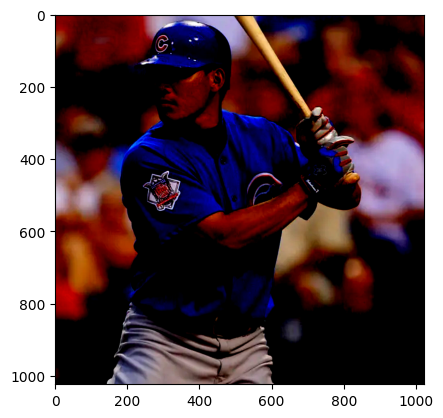

In [41]:
url = "https://cdn.vox-cdn.com/thumbor/JFRMyKpqXDf9AzCLwkXkameOKPA=/166x619:2000x2797/920x613/filters:focal(912x677:1232x997):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/72951367/123951100.0.jpg"
response = requests.get(url)
processed_images = preprocess(Image.open(BytesIO(response.content)).convert("RGB"), jnp.float32)
print(processed_images.shape)
plt.imshow(processed_images[0].transpose(1,2,0))

In [ ]:
positive_prompt = "A cinematic film still of Morgan Freeman dressed in yellow with a baseball bat, portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic"
negative_prompt = None
prng_seed = replicate(jax.random.PRNGKey(default_seed))
positive_input_ids = replicate(tokenise_prompts(positive_prompt))
p_processed_images = replicate(processed_images)
# prng_seed = jax.random.PRNGKey(default_seed)
# positive_input_ids = tokenise_prompts(positive_prompt)
print(positive_input_ids.shape)

In [ ]:
print("Start Compiling...")
start = time.time()
latents = generate_latents(positive_input_ids, negative_prompt, p_processed_images, prng_seed, strength, guidance_scale)
print(f"Compiled in {time.time() - start}")
del sdxl_params_text_encoder_1
del text_encoder_1
del sdxl_params_base_unet
del unet_base_module
print("Latents calculated")


# figsize=(10,10)
# # key = jax.random.PRNGKey(42)
# # test_image = jax.random.normal(key, shape=(1024,1024, 3))
# # test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

# plt.figure(figsize=figsize)
# plt.axis('off')
# # plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
# plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [ ]:
jax.numpy.save('latents_file', latents)

In [ ]:
asdff43

# Refiner step

In [42]:
with open('/kaggle/working/latents_file.npy', 'rb') as f:
    latents = jnp.load(f)

In [10]:
type(latents)

jaxlib.xla_extension.ArrayImpl

In [11]:
loaded_model = load_file("/kaggle/input/sdxl-refiner-unet/diffusion_pytorch_model.safetensors")
flax_model = dict()
lookup_list = ['.0', '.1' ,'.2', '.3' ,'.4' ,'.5', '.6', '.7', '.8' ,'.9']
for key, value in loaded_model.items():
    for check_str in lookup_list:                                                                                                                                                                                                         
        key = key.replace(check_str,'_'+check_str[-1])
    
    if 'block' and 'norm' in key:
        keys = key.replace('weight','scale').split('.')
    else:
        keys = key.replace('weight','kernel').split('.')
    
    current = flax_model
    for x in keys:
        if x in current.keys():
            if x == keys[-1]:
                if x == 'kernel':
                    current[x] = value.T
                else:
                    current[x] = value
                    
            current = current[x]
        elif x == keys[-1]:
            if x == 'kernel':
                current[x] = value.T
            else:
                current[x] = value
        else:
            current[x] = {}        
            current = current[x]
            
flax_model.keys()

dict_keys(['add_embedding', 'conv_in', 'conv_norm_out', 'conv_out', 'down_blocks_0', 'down_blocks_1', 'down_blocks_2', 'down_blocks_3', 'mid_block', 'time_embedding', 'up_blocks_0', 'up_blocks_1', 'up_blocks_2', 'up_blocks_3'])

In [12]:
sdxl_params_refiner_unet = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), flax_model)}
del flax_model

In [34]:
unet_refiner_module_config = FlaxUNet2DConditionModel.load_config('/kaggle/input/sdxl-refiner-unet')
unet_refiner_module = FlaxUNet2DConditionModel.from_config(unet_refiner_module_config)

In [35]:
type(unet_refiner_module)

diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel

In [14]:
from transformers import FlaxCLIPTextModelWithProjection
refiner_text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/sdxl-refiner-tokenizer2')
sdxl_params_refiner_text_encoder_2 = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), refiner_text_encoder_2.params)}

In [36]:
@partial(
    jax.pmap,
    in_axes=(0, 0, 0, 0, None, None),
    static_broadcasted_argnums=(4, 5),
)
def generate_image(
    latents,
    positive_input_ids,
    negative_input_ids=None,
    prng_seed=jax.random.PRNGKey(42),
    strength=0.9,
    guidance_scale=5.0
):
    print(positive_input_ids.shape)
    def get_refiner_embeddings(prompt_ids):
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]

        prompt_embeds_2 = refiner_text_encoder_2(te_2_inputs,params=sdxl_params_refiner_text_encoder_2['params'], output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = prompt_embeds_2
        pooled_embeds = refiner_text_encoder_2(te_2_inputs,params=sdxl_params_refiner_text_encoder_2['params'], output_hidden_states=True)["text_embeds"]

        return prompt_embeds, pooled_embeds
    
    positive_refiner_prompt_embeds, positive_refiner_pooled_embeds = get_refiner_embeddings(positive_input_ids)
    batch_size = positive_refiner_prompt_embeds.shape[0]
    print("positive_refiner_prompt_embeds: ", positive_refiner_prompt_embeds.shape)
    if negative_input_ids is None:
        negative_refiner_prompt_embeds = jnp.zeros_like(positive_refiner_prompt_embeds)
        negative_refiner_pooled_embeds = jnp.zeros_like(positive_refiner_pooled_embeds)
    else:       
        negative_refiner_prompt_embeds, negative_refiner_pooled_embeds = get_refiner_embeddings(negative_input_ids)
        
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    
    latents_shape = latents.shape
    print("latents_shape: ", latents_shape)
    
    def get_timestep_start(strength):
    # get the original timestep using init_timestep
#         init_timestep = min((num_inference_steps * strength).astype(int), num_inference_steps)

        t_start = num_steps - int(num_steps * strength)

        return t_start
    
    start_timestep = get_timestep_start(strength)    
    
    prompt_refiner_embeds = jnp.concatenate([negative_refiner_prompt_embeds, positive_refiner_prompt_embeds], axis=0)  # (2, 77, 2048)
    
    num_micro_conditions = 5

    text_embeds_dim = unet_refiner_module.config.projection_class_embeddings_input_dim - (
        num_micro_conditions * unet_refiner_module.config.addition_time_embed_dim
    )

    time_ids_channels = unet_refiner_module.projection_class_embeddings_input_dim - text_embeds_dim
    time_ids_dims = time_ids_channels // unet_refiner_module.addition_time_embed_dim
    time_ids = height*jnp.ones((1, time_ids_dims), dtype=jnp.float32)
    
    add_refiner_text_embeds = jnp.concatenate([negative_refiner_pooled_embeds, positive_refiner_pooled_embeds], axis=0)
    add_refiner_time_ids = jnp.concatenate([time_ids, time_ids], axis=0)
    print("add_refiner_text_embeds: ", add_refiner_text_embeds.shape)
    
    added_refiner_cond_kwargs = {"text_embeds": add_refiner_text_embeds, "time_ids": add_refiner_time_ids}    
    
    def refiner_loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)
        print("timestep: ", (jnp.array(timestep, dtype=jnp.int32)))
        # predict the noise residual
        noise_pred = unet_refiner_module.apply(
            sdxl_params_refiner_unet,
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_refiner_embeds,
            added_cond_kwargs=added_refiner_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
        
    
    scheduler_state = scheduler_module.set_timesteps(sdxl_params_scheduler['params'], num_inference_steps=num_steps, shape=latents_shape)
    
    latents, _ = jax.lax.fori_loop(start_timestep, num_steps, refiner_loop_body, (latents, scheduler_state))
    
#     latents = latents/scheduler_state.init_noise_sigma
    latents = 1 / vae_module.config.get("scaling_factor") * latents
    
    image = vae_module.apply(sdxl_params_vae, latents, method=vae_module.decode).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    
    return image

In [21]:
vae_scale_factor = 2 ** (len(vae_module.config.block_out_channels) - 1)
height = unet_refiner_module.__getitem__('sample_size') * vae_scale_factor
width = unet_refiner_module.__getitem__('sample_size') * vae_scale_factor

height, width

(1024, 1024)

In [26]:
positive_prompt = "A cinematic film still of Morgan Freeman dressed in yellow with a baseball bat, portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic"
negative_prompt = None
prng_seed = replicate(jax.random.PRNGKey(default_seed))
positive_input_ids = replicate(tokenise_prompts(positive_prompt))

Start Compiling...
(1, 2, 77)
positive_refiner_prompt_embeds:  (1, 77, 1280)
latents_shape:  (1, 4, 128, 128)
add_refiner_text_embeds:  (2, 1280)
timestep:  Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace(level=1/1)>
Compiled in 414.60236144065857


TypeError: Invalid shape (1, 1024, 1024, 3) for image data

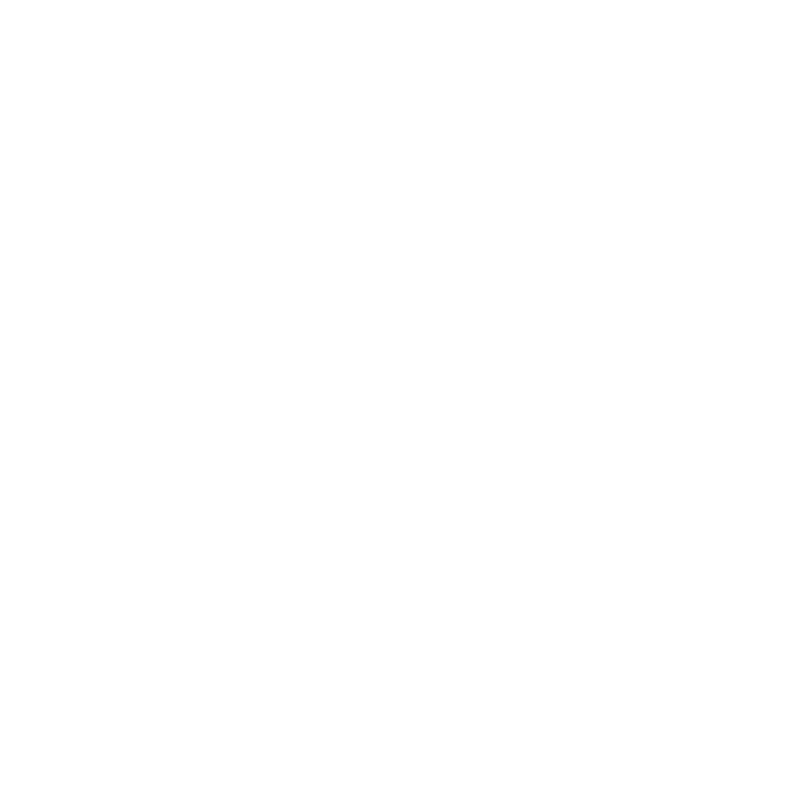

In [37]:
print("Start Compiling...")
start = time.time()
gen_image = generate_image(latents,positive_input_ids, negative_prompt, prng_seed, strength, guidance_scale)
print(f"Compiled in {time.time() - start}")
# convert the images to PIL
# output_images = numpy_to_pil(np.array((gen_image.reshape((gen_image.shape[0] * gen_image.shape[1], ) + gen_image.shape[-3:]))))
# make_image_grid(output_images, 2, 4)

figsize=(10,10)
plt.figure(figsize=figsize)
plt.axis('off')
# plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [43]:
latents = 1 / vae_module.config.get("scaling_factor") * latents[0]

image = vae_module.apply(sdxl_params_vae, latents, method=vae_module.decode).sample
image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)



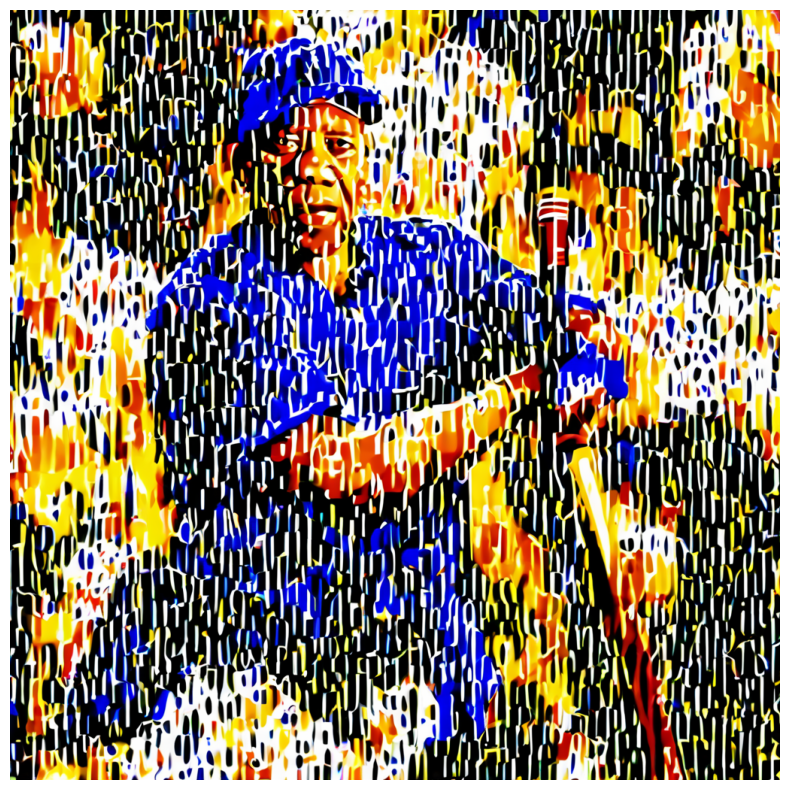

In [45]:
figsize=(10,10)
plt.figure(figsize=figsize)
plt.axis('off')
# plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
plt.imshow(image[0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [ ]:
sdgdfg

In [ ]:
positive_prompt = '''Boy dressed in green hitting with a baseball bat. Realistic. portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic'''
positive_input_ids = replicate(tokenise_prompts(positive_prompt))

In [ ]:
jnp.arange(0.875,0.925,(0.925-0.875)/8.0)

In [ ]:
print("Start Compiling")
start = time.time()
gen_image = generate_image(positive_input_ids, negative_prompt, processed_images, prng_seed, strength, guidance_scale, num_steps)
print(f"Compiled in {time.time() - start}")
output_images = numpy_to_pil(np.array((gen_image.reshape((gen_image.shape[0] * gen_image.shape[1], ) + gen_image.shape[-3:]))))
make_image_grid(output_images, 2, 4)

# figsize=(10,10)
# # key = jax.random.PRNGKey(42)
# # test_image = jax.random.normal(key, shape=(1024,1024, 3))
# # test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

# plt.figure(figsize=figsize)
# plt.axis('off')
# # plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
# plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [ ]:
;klujyhtr

In [ ]:
def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    print("add_time_ids.shape: ", add_time_ids, bs)
    add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
    return add_time_ids

def get_refiner_embeddings(prompt_ids):
    te_1_inputs = prompt_ids[:, 0, :]
    te_2_inputs = prompt_ids[:, 1, :]

    prompt_embeds_1 = text_encoder_1(te_1_inputs,params=sdxl_params_text_encoder_1['params'], output_hidden_states=True)["hidden_states"][-2]
    prompt_embeds_2 = refiner_text_encoder_2(te_2_inputs,params=sdxl_params_refiner_text_encoder_2['params'], output_hidden_states=True)["hidden_states"][-2]
    print("prompt_embeds_1: ", prompt_embeds_1.shape, prompt_embeds_2.shape)
    prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
    pooled_embeds = refiner_text_encoder_2(te_2_inputs,params=sdxl_params_refiner_text_encoder_2['params'], output_hidden_states=True)["text_embeds"]

    return prompt_embeds, pooled_embeds

negative_input_ids = None
positive_refiner_prompt_embeds, positive_refiner_pooled_embeds = get_refiner_embeddings(positive_input_ids)
print("positive_refiner_prompt_embeds, positive_refiner_pooled_embeds: ", positive_refiner_prompt_embeds.shape, positive_refiner_pooled_embeds.shape)
batch_size = positive_refiner_prompt_embeds.shape[0]
print("positive_refiner_prompt_embeds: ", positive_refiner_prompt_embeds.shape)
if negative_input_ids is None:
    negative_refiner_prompt_embeds = jnp.zeros_like(positive_refiner_prompt_embeds)
    negative_refiner_pooled_embeds = jnp.zeros_like(positive_refiner_pooled_embeds)
else:       
    negative_refiner_prompt_embeds, negative_refiner_pooled_embeds = get_refiner_embeddings(negative_input_ids)

prompt_refiner_embeds = jnp.concatenate([negative_refiner_prompt_embeds, positive_refiner_prompt_embeds], axis=0)  # (2, 77, 2048)

num_micro_conditions = 5

text_embeds_dim = unet_refiner_module.config.projection_class_embeddings_input_dim - (
    num_micro_conditions * unet_refiner_module.config.addition_time_embed_dim
)

time_ids_channels = unet_refiner_module.projection_class_embeddings_input_dim - text_embeds_dim
time_ids_dims = time_ids_channels // unet_refiner_module.addition_time_embed_dim
time_ids = 128*jnp.ones((1, time_ids_dims), dtype=jnp.float32)

add_refiner_text_embeds = jnp.concatenate([negative_refiner_pooled_embeds, positive_refiner_pooled_embeds], axis=0)
add_refiner_time_ids = jnp.concatenate([time_ids, time_ids], axis=0)
print("add_refiner_text_embeds: ", add_refiner_text_embeds.shape)

In [ ]:
scheduler_state = scheduler_module.set_timesteps(
        scheduler_params, num_inference_steps=num_steps, shape=(1,4,128,128)
)

In [ ]:
add_refiner_time_ids.shape

In [ ]:
from diffusers.models.unet_2d_condition_flax import FlaxTimesteps, FlaxTimestepEmbedding
from diffusers.models.embeddings_flax import get_sinusoidal_embeddings
time_emb = get_sinusoidal_embeddings(jnp.ravel(add_refiner_time_ids),embedding_dim=unet_refiner_module.addition_time_embed_dim,flip_sin_to_cos=unet_refiner_module.flip_sin_to_cos,freq_shift=unet_refiner_module.freq_shift)
print(time_emb.shape)
time_emb = jnp.reshape(time_emb, (add_refiner_text_embeds.shape[0], -1))
time_emb.shape

In [ ]:
text_embedz = jax.random.normal(jax.random.PRNGKey(45), (1,1280))
add_embeds = jnp.concatenate([add_refiner_text_embeds, time_emb], axis=-1)
add_embeds.shape

In [ ]:
from flax import linen as nn  # Linen API

class test_module(nn.Module):
    time_embed_dim: int = unet_refiner_module.block_out_channels[0] * 4
    dtype: jnp.dtype = jnp.float32

    @nn.compact
    def __call__(self, temb):
        temb = nn.Dense(self.time_embed_dim, dtype=self.dtype, name="linear_1")(temb)
        temb = nn.silu(temb)
        temb = nn.Dense(self.time_embed_dim, dtype=self.dtype, name="linear_2")(temb)
        return temb
    
model_temb = test_module()
mod_params = {'params': {'linear_1': {'bias': sdxl_params_refiner_unet['params']['add_embedding']['linear_1']['bias'],
                                      'kernel': sdxl_params_refiner_unet['params']['add_embedding']['linear_1']['kernel']
                                     },
                         'linear_2': {'bias': sdxl_params_refiner_unet['params']['add_embedding']['linear_2']['bias'],
                                      'kernel': sdxl_params_refiner_unet['params']['add_embedding']['linear_2']['kernel']
                                     }           
                        }
             }

aug_emb = model_temb.apply(mod_params,add_embeds)
aug_emb.shape

In [ ]:
conv_in = nn.Conv(
    unet_refiner_module.block_out_channels[0],
    kernel_size=(3, 3),
    strides=(1, 1),
    padding=((1, 1), (1, 1)),
    dtype=dtype,
)

conv_in_params = {'params': {'bias': sdxl_params_refiner_unet['params']['conv_in']['bias'],
                             'kernel': sdxl_params_refiner_unet['params']['conv_in']['kernel']
                            }
                 }
latents_input = jax.random.normal(jax.random.PRNGKey(46),(1,4,128,128))
latents_input = np.transpose(latents_input, (0, 2, 3, 1))
sample = conv_in.apply(conv_in_params,latents_input)
sample.shape

In [ ]:
sample.shape, aug_emb.shape

In [ ]:
import flax
serialised_params = flax.serialization.msgpack_serialize(ref_unet_pytree, in_place=False)

In [ ]:
import msgpack

# Write msgpack file
with open("data.msgpack", "wb") as outfile:
    packed = msgpack.packb(serialised_params)
    outfile.write(packed)

In [ ]:
jax.tree_util.tree_structure(sdxl_params_base_unet)

In [ ]:
sdxl_params_base_unet['params']['down_blocks_1']['attentions_0']['transformer_blocks_0']['attn2']['to_k']['kernel'].shape

In [ ]:
sdxl_params_refiner_unet['params']['down_blocks_1']['attentions_0']['transformer_blocks_0']['attn2']['to_k']['kernel'].shape

In [ ]:
jax.random.normal(jax.random.PRNGKey(561),(1,2816,1280))@jax.random.normal(jax.random.PRNGKey(23),(1,4,128,128))

In [ ]:
sdxl_params_refiner_text_encoder_2['params']['text_model']['embeddings']['position_embedding']['embedding'].shape

In [ ]:
sdxl_params_refiner_unet['params']['add_embedding']['linear_1']['kernel']